In [ ]:
# !unzip '/content/drive/MyDrive/crim.zip' -d '/content/drive/MyDrive/data/'

라이브러리 로드

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
pd.options.display.max_columns = None

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/data/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/data/test.csv')
np.unique( train_df['월']), np.unique( test_df['월'])

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]))

한글처리

In [ ]:
!sudo apt-get install -y fonts-nanum
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
plt.rcParams['font.family'] = "NanumBarunGothic"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (6,417 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 122400 files and di

이상치 탐색
  - 날씨와 관련된 데이터가 있고 해당 날씨는 특정 달에 편차가 심하므로 이상치로 보지 않고 하나의 특성으로 본다
  - 이상치 제거는 하지 않은 것으로 결론
  - 이상치에 해당하는 데이터는 2월에 집중되어 있음 
  - 강수량 적설량 강설량과 범죄와의 상관관계가 있는지 조사하고 없으면 해당 컬럼을 제거해도 무방할 것 같음
  - 일단 1차로 모든 데이터를 사용할 것임

In [ ]:
train_df.loc[:,'소관경찰서':'범죄발생지'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84406 entries, 0 to 84405
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   소관경찰서    84406 non-null  int64  
 1   소관지역     84406 non-null  float64
 2   사건발생거리   84406 non-null  float64
 3   강수량(mm)  84406 non-null  float64
 4   강설량(mm)  84406 non-null  float64
 5   적설량(cm)  84406 non-null  float64
 6   풍향       84406 non-null  float64
 7   안개       84406 non-null  float64
 8   짙은안개     84406 non-null  float64
 9   번개       84406 non-null  float64
 10  진눈깨비     84406 non-null  float64
 11  서리       84406 non-null  float64
 12  연기/연무    84406 non-null  float64
 13  눈날림      84406 non-null  float64
 14  범죄발생지    84406 non-null  object 
dtypes: float64(13), int64(1), object(1)
memory usage: 9.7+ MB


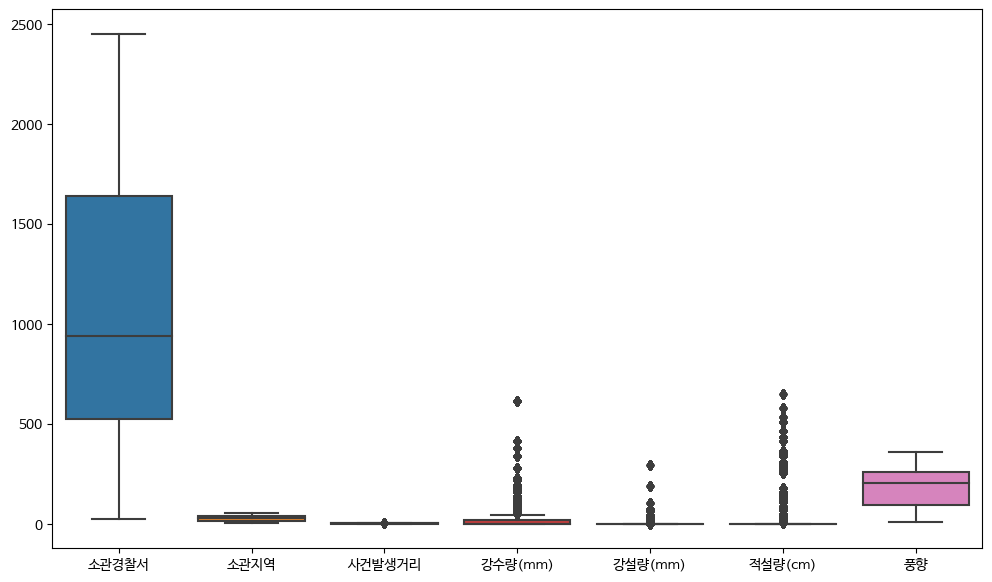

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,7))
sns.boxplot(train_df.loc[:,'소관경찰서':'풍향'])
plt.show()

In [ ]:
def removeOutLier(df = train_df,display=False):
  temp = df.loc[:,'강수량(mm)':'적설량(cm)']
  q1 = temp.quantile(0.25)
  q3 = temp.quantile(0.75)
  IQR = q3 - q1
  IQR     
  iqr_index = temp[((temp<(q1-1.5*IQR)) | (temp > (q3 + 1.5*IQR))).any(axis=1)].index
  df = df.drop(iqr_index)
  
  if display : 
    plt.figure(figsize=(12,5))
    sns.boxplot(df.loc[:,'강수량(mm)':'적설량(cm)'])
    plt.xticks(rotation = 45)
    plt.show()
  return df
# train_df_iqr =  removeOutLier() 
# test_df_iqr =  removeOutLier(test_df) 
# print(train_df_iqr.shape, test_df_iqr.shape)
# # 트레인 데이터는 타겟이 있어서 컬럼수가 다르다
# # 범주형 데이터의 개수가 맞는지 확인한다.
# np.unique( test_df_iqr['월'])

oneHotEncoding : 월,	요일,	시간, 범죄발생지

스케일링 : 소관경찰서,	소관지역,	사건발생거리,	강수량(mm),	강설량(mm)	,적설량(cm),	풍향

binary data : 안개,	짙은안개,	번개,	진눈깨비,	서리,	연기/연무,	눈날림

In [ ]:
def makeOneHot(df):
  pd_oneHot =  pd.concat([ pd.get_dummies(df['월'],prefix='월').reset_index(drop=True),
                          pd.get_dummies(df['요일'],prefix='요일').reset_index(drop=True),
                          pd.get_dummies(df['시간'],prefix='시간').reset_index(drop=True),
                          pd.get_dummies(df['범죄발생지'],prefix='범죄발생지').reset_index(drop=True)
                    ],axis=1)
  return pd_oneHot
# 불필요한 컬럼은 제거한다.
trainX = train_df.iloc[:,1:-1]
y = train_df.iloc[:,-1]

testX =  test_df.iloc[:,1:]
print(trainX.shape, testX.shape)

train_oneHot = makeOneHot(trainX)
test_oneHot = makeOneHot(testX)
print(train_oneHot.shape, test_oneHot.shape)

(84406, 18) (17289, 18)
(84406, 45) (17289, 45)


In [ ]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
def scalingData(scaler,data):  
  scaler.fit( train_df.loc[:,'소관경찰서':'풍향'] )  #train test 상관없이 학습기준이 되는 train으로 스케일링 규칙을 정한다
  scaled_data = scaler.transform(data.loc[:,'소관경찰서':'풍향'] )
  return pd.DataFrame(scaled_data, columns=data.loc[:,'소관경찰서':'풍향'].columns)

In [ ]:
rs = RobustScaler()
train_df_scaled = scalingData(rs,train_df)
test_df_scaled = scalingData(rs,test_df)
train_df_scaled.shape, test_df_scaled.shape

((84406, 7), (17289, 7))

oneHotEncoding + 스케일링 + binary data

In [ ]:
train = pd.concat( [train_oneHot, train_df_scaled, train_df.loc[:,'안개':'눈날림'].reset_index(drop=True)]  ,axis=1)
test = pd.concat( [test_oneHot, test_df_scaled, test_df.loc[:,'안개':'눈날림'].reset_index(drop=True)]  ,axis=1)
train.shape, test.shape

((84406, 59), (17289, 59))

In [ ]:
!pip install efficientnet_pytorch
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


머신러닝 모델을 리스트에 저장해서 교차검증을 통한 성능 비교 및 모델 선택하기(데이터는 정규화 되어 있음)

In [ ]:
import sklearn 
from sklearn.neighbors import KNeighborsClassifier #Classifier implementing the k-nearest neighbors vote
from sklearn.tree import DecisionTreeClassifier## is a class capable of performing multiclass classification on a dataset.
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier#Iteratively trains because at each time step the partial derivatives of the loss function with respect to the model parameters are computed. 
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import BayesianGaussianMixture
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as ltb
import xgboost as xgb
import catboost as cb
from sklearn.ensemble import GradientBoostingClassifier
from efficientnet_pytorch import EfficientNet
# 교차 검증
from sklearn.model_selection import cross_validate
# 특성을 추가하여 비 선형으로 만들기
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
#create List models 
models = []
models.append(('KNN', KNeighborsClassifier()))
# models.append(('SVM', SVC()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('LogisticRegression', LogisticRegression(max_iter=1000)))
# models.append(('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()))
# models.append(('GaussianNB', GaussianNB()))
models.append(('MLPClassifier', MLPClassifier()))
# models.append(('BayesianGaussianMixture', BayesianGaussianMixture()))
models.append(('SGDClassifier', SGDClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier()))

models.append(('LGBMClassifier', ltb.LGBMClassifier()))
models.append(('XGBClassifier', xgb.XGBClassifier()))
models.append(('CatBoostClassifier', cb.CatBoostClassifier()))


In [ ]:
# calculate accuracy
from sklearn.model_selection import train_test_split , cross_val_score,KFold,GridSearchCV
scoring_=[]
name_m=[]
from tqdm import tqdm
for i in  tqdm(range(len(models))):
    kfold = KFold(n_splits=5, shuffle=True, random_state=43)
    scor = cross_val_score(models[i][1], train, y, cv=kfold, scoring='accuracy')  
    scoring_.append(scor)
    name_m.append(models[i][0])
    print("{} : score {:.3f} ".format(models[i][0]  , np.mean(scoring_)  ))

In [ ]:
mlp = MLPClassifier(max_iter=1000,early_stopping=True,n_iter_no_change=10,learning_rate='invscaling',solver ='adam')
kfold = KFold(n_splits=5, shuffle=True, random_state=43)
scor = cross_val_score(mlp, train, y, cv=kfold, scoring='accuracy')

array([0.54045729, 0.53255139, 0.53130739, 0.53243291, 0.53266987])

In [ ]:
np.mean(scor)

0.5338837692400713

In [ ]:
logistic_lr = LogisticRegression(max_iter=1000,solver = 'liblinear')
kfold = KFold(n_splits=5, shuffle=True, random_state=43)
scor = cross_val_score(logistic_lr, train, y, cv=kfold, scoring='accuracy')

In [ ]:
np.mean(scor)

0.5325805766325097

In [ ]:
np.mean(scoring_,axis=1)

array([0.45592729, 0.43764658, 0.53250949, 0.51608883, 0.48962146,
       0.51800815, 0.54733068, 0.54964093, 0.54711743, 0.54789934])

In [ ]:
np.argsort(np.mean(scoring_,axis=1))[::-1].tolist()

[7, 9, 6, 8, 2, 5, 3, 4, 0, 1]

In [ ]:
[ models[i][0] for i in np.argsort(np.mean(scoring_,axis=1))[::-1]  ]

['LGBMClassifier',
 'CatBoostClassifier',
 'GradientBoostingClassifier',
 'XGBClassifier',
 'LogisticRegression',
 'RandomForestClassifier',
 'MLPClassifier',
 'SGDClassifier',
 'KNN',
 'DecisionTreeClassifier']

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split

parameter = {
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_child_samples': [10, 20, 30]
}
# x_train,x_test,y_train,y_test = train_test_split(train,y,random_state=100)
# rsc = RandomizedSearchCV(ltb.LGBMClassifier(),param_distributions=parameter)
# rsc.fit(x_train,y_train)

In [ ]:
# model = rsc.best_estimator_
# model.score(x_train,y_train), model.score(x_test,y_test)

(0.5755086566409705, 0.5494739835086722)

In [ ]:
rsc = RandomizedSearchCV(ltb.LGBMClassifier(),param_distributions=parameter)
rsc.fit(train,y)

RandomizedSearchCV(estimator=LGBMClassifier(),
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'min_child_samples': [10, 20, 30],
                                        'n_estimators': [100, 200, 300],
                                        'num_leaves': [20, 30, 40]})

In [ ]:
best_model = rsc.best_estimator_
predic_data = best_model.predict(test)
result = pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv')
result['TARGET'] = predic_data
result.to_csv('result.csv',index=False)

머신러닝을 좀더 빠르고 효율적으로 모델 탐색 하기 - AUTOML

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/data/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/data/test.csv')
train_df.pop('ID')
test_df.pop('ID')

In [ ]:
train_df.info()

In [ ]:
train_df.columns

In [ ]:
for col in ['월', '요일', '시간', '소관경찰서','소관지역']:
  print(train_df[col].value_counts())
  print("*"*20)

In [ ]:
# train_df['월'].value_counts() / len(train_df['월']) < 0.05
temp = train_df['월'].value_counts()
temp[train_df['월'].value_counts() / len(train_df['월']) < 0.001].index
def findLowCardinality(col):
  temp = train_df[col].value_counts()
  return temp[train_df[col].value_counts() / len(train_df[col]) < 0.001].index

In [ ]:
for col in ['월', '요일', '시간', '소관경찰서','소관지역']:
  print( findLowCardinality(col) )

Int64Index([], dtype='int64')
Index([], dtype='object')
Int64Index([], dtype='int64')
Int64Index([1527, 1546, 727, 726, 1529], dtype='int64')
Float64Index([], dtype='float64')


In [ ]:
# cardinality가 low한 값을 nan으로 변경
train_df.loc[train_df['소관경찰서'] == 1527, '소관경찰서'] = np.nan
train_df.loc[train_df['소관경찰서'] == 1546, '소관경찰서'] = np.nan
train_df.loc[train_df['소관경찰서'] == 727, '소관경찰서'] = np.nan
train_df.loc[train_df['소관경찰서'] == 726, '소관경찰서'] = np.nan
train_df.loc[train_df['소관경찰서'] == 1529, '소관경찰서'] = np.nan
train_df.loc[train_df['월'] == 12, '월'] = np.nan

In [ ]:
train_df['범죄발생지'].value_counts()
train_df.loc[train_df['범죄발생지'] == '공원', '범죄발생지'] = np.nan
train_df.loc[train_df['범죄발생지'] == '학교', '범죄발생지'] = np.nan
train_df.loc[train_df['범죄발생지'] == '약국', '범죄발생지'] = np.nan
train_df.loc[train_df['범죄발생지'] == '호텔/모텔', '범죄발생지'] = np.nan
train_df.loc[train_df['범죄발생지'] == '병원', '범죄발생지'] = np.nan
train_df.loc[train_df['범죄발생지'] == '은행', '범죄발생지'] = np.nan

In [ ]:
# import
from pycaret.classification import * 

In [ ]:
train_df
categorical_features = ['월'	,'요일'	,'시간',	'범죄발생지']
clf = setup(data=train_df, 
            target='TARGET', 
            # ignore_features=ignore_features,           # 분석/학습에 고려하지 않을 feature(컬럼) 제거
            categorical_features=categorical_features, # 범주형 컬럼 지정
            # numeric_features=numeric_features,         # 수치형 컬럼 지정
            normalize=True,                            # 정규화 적용
            normalize_method='zscore',                 # 정규화 방식 지정
            imputation_type='iterative',               # 결측치를 lightgbm으로 예측하여 채움
            iterative_imputation_iters=10,             # imputation iteration 지정
            categorical_iterative_imputer='lightgbm',
            # bin_numeric_features=['age', 'trestbps', 'chol','thalach', 'oldpeak'], # numeric 컬럼에 대하여 binning
            polynomial_features=True,
            session_id=2023             
            ) 


,Description,Value
0,Session id,2023
1,Target,TARGET
2,Target type,Multiclass
3,Original data shape,"(84406, 19)"
4,Transformed data shape,"(84406, 1653)"
5,Transformed train set shape,"(59084, 1653)"
6,Transformed test set shape,"(25322, 1653)"
7,Numeric features,14
8,Categorical features,4
9,Rows with missing values,5.3%


In [ ]:
best_models = compare_models(sort='f1', n_select=5, fold=5)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,08:19:49
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,SVM - Linear Kernel


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5204,0.6665,0.5204,0.5133,0.5076,0.2421,0.2475,486.9180
dt,Decision Tree Classifier,0.4294,0.5623,0.4294,0.4297,0.4295,0.1248,0.1248,127.0420
knn,K Neighbors Classifier,0.4495,0.5902,0.4495,0.4318,0.4278,0.1207,0.1254,266.0460
nb,Naive Bayes,0.3437,0.6181,0.3437,0.5225,0.2684,0.0899,0.1551,109.7080


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

################################################################

In [ ]:
!pip install pycaret
from pycaret import classification
classification.setup(data=train_df,target='TARGET',                     
                #  remove_outliers=True)
                remove_outliers=False)

In [ ]:
best = classification.compare_models(n_select=5,fold=5)

In [ ]:
# from sklearn.preprocessing import RobustScaler
# test_df = RobustScaler().fit_transform(test_df)
result = []
for model in best:
  try:
    result.append(model.predict_proba(test_df))
  except:
    print(model)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, positive=False, random_state=8524, solver='auto',
                tol=0.0001)


In [ ]:
np.array(result).mean(axis=0)

array([[0.33914404, 0.24495388, 0.41590208],
       [0.54099631, 0.22037415, 0.23862953],
       [0.52553493, 0.25838381, 0.21608128],
       ...,
       [0.42443229, 0.33779212, 0.23777558],
       [0.50883099, 0.21096225, 0.28020676],
       [0.17060667, 0.72793402, 0.10145931]])

In [ ]:
predic_data = [np.argmax(i) for i in np.array(result).mean(axis=0)]

In [ ]:
predic_data[:3]

[2, 0, 0]

In [ ]:
result = pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv')
result['TARGET'] = predic_data
result.to_csv('result.csv',index=False)